In [1]:
# 1. Dataset Selection
## Dataset Description:
###For this mini-project, I have chosen the weather dataset for COVID-19 analysis from Kaggle. The dataset contains information about weather conditions and COVID-19 statistics across different regions.

###- **Size**: 17,892 entries with 20 columns.
###- **Features**: Includes weather-related attributes like temperature, wind speed, relative humidity, etc., along with COVID-19 related features like confirmed cases and fatalities.
###- **Missing Values**: Several columns contain significant missing data, making it suitable for exploring different techniques to handle missing values.

## Objectives:
###-1. Clean the dataset by handling missing values using various techniques (imputation, removal, interpolation).
###-2. Explore relationships between weather data and COVID-19 statistics.
###-3. Apply basic regression or clustering models to understand data patterns.

## Working Plan:
###-1. Evaluate the data quality and identify missing values.
###-2. Handle missing values using different strategies.
###-3. Perform Exploratory Data Analysis (EDA) to examine relationships between weather and COVID-19 data.
###-4. Apply a regression or clustering model.
###-5. Communicate results, including insights and visualizations.

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Loading the dataset
df = pd.read_csv("training_data_with_weather_info_week_1.csv")

# Display the first few rows
df.head()


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,day_from_jan_first,temp,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,22,42.6,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,23,42.0,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,24,40.1,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,25,46.0,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,26,42.8,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1


In [4]:
# 2. Data Cleaning

## Data Quality Evaluation:
# Checking for missing values, data types, and general statistics
df.info()  # To check data types and null values
df.describe()  # To get statistical details of the data

# start cleaning
# List of numerical columns (you can modify this based on your dataset)
numerical_columns = [
    'ConfirmedCases', 'Fatalities', 'day_from_jan_first', 'temp', 'min', 'max',
    'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp'
]

# Handle inf values by replacing them with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values for numerical columns
imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to 'median', 'most_frequent', or 'constant'
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Handle categorical columns
# For simplicity, let's assume 'Province/State' is categorical and needs to be filled
df['Province/State'].fillna('Unknown', inplace=True)

# Additional cleaning for 'Date' column (if it's not in datetime format yet)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime, invalid entries will become NaT

# Handle rows with NaT in 'Date' column by filling or dropping (based on your need)
df.dropna(subset=['Date'], inplace=True)  # Dropping rows with invalid dates

# Fill missing 'Lat' and 'Long' with the mean value for these columns if they are numeric
df['Lat'].fillna(df['Lat'].mean(), inplace=True)
df['Long'].fillna(df['Long'].mean(), inplace=True)

# Check the cleaned dataset
print(df.info())

# Show the first few rows of the cleaned dataset
print(df.head())
# Check for duplicates after cleaning
df.drop_duplicates(inplace=True)

# Splitting Data for Training and Validation

# Define your features (X) and target variable (y)
X = df.drop(columns=['ConfirmedCases', 'Fatalities'])  # Features (excluding target)
y = df['ConfirmedCases']  # Target variable (ConfirmedCases or Fatalities)

# Split the data: 80% for training, 20% for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split data
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17892 entries, 0 to 17891
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  17892 non-null  int64         
 1   Province/State      17892 non-null  object        
 2   Country/Region      17892 non-null  object        
 3   Lat                 17892 non-null  float64       
 4   Long                17892 non-null  float64       
 5   Date                17892 non-null  datetime64[ns]
 6   ConfirmedCases      17892 non-null  float64       
 7   Fatalities          17892 non-null  float64       
 8   day_from_jan_first  17892 non-null  float64       
 9   temp                17892 non-null  float64       
 10  min                 17892 non-null  float64       
 11  max                 17892 non-null  float64       
 12  stp                 17892 non-null  float64       
 13  slp                 17892 non-null  float64   

<ipython-input-4-f6b23621ba6a>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Province/State'].fillna('Unknown', inplace=True)
<ipython-input-4-f6b23621ba6a>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

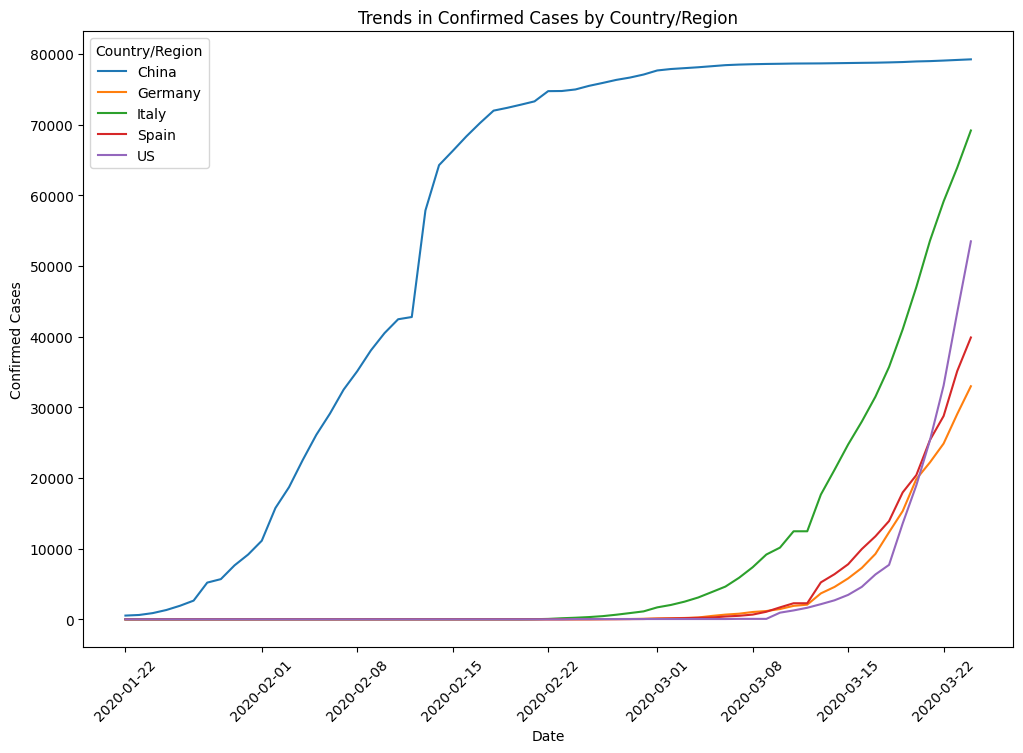

In [12]:
# 3.  Exploratory Data Analyses
# Extract day of week and month from Date
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Calculate moving average for ConfirmedCases (7-day rolling window)
df['ConfirmedCases_MA7'] = df['ConfirmedCases'].rolling(window=7).mean()

# Calculate the difference between ConfirmedCases and Fatalities
df['CaseFatalityRate'] = df['Fatalities'] / df['ConfirmedCases']

from scipy import stats

# Identify outliers in 'ConfirmedCases' and 'Fatalities' using Z-score
z_scores = stats.zscore(df[['ConfirmedCases', 'Fatalities']])
df_outliers = df[(np.abs(z_scores) > 3).all(axis=1)]  # Filtering rows with Z-scores > 3
df_outliers

# Group by Country/Region and Date
top_countries = df.groupby(['Country/Region', 'Date']).agg({
    'ConfirmedCases': 'sum',
    'Fatalities': 'sum'
}).reset_index()

# Get top 5 countries with the highest confirmed cases
top_5_countries = top_countries.groupby('Country/Region').agg({
    'ConfirmedCases': 'max'
}).nlargest(5, 'ConfirmedCases').index

top_5_df = top_countries[top_countries['Country/Region'].isin(top_5_countries)]

# Plot trends for the top 5 countries
plt.figure(figsize=(12, 8))
sns.lineplot(data=top_5_df, x='Date', y='ConfirmedCases', hue='Country/Region')
plt.title("Trends in Confirmed Cases by Country/Region")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.xticks(rotation=45)
plt.show()


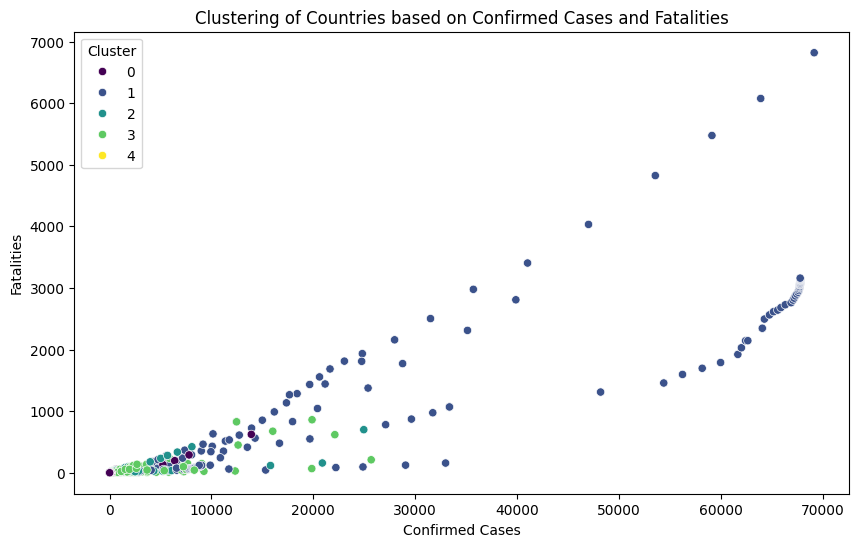

Mean Squared Error: 130777.3904086858
R² Score: 0.9869667403008529


In [14]:
# 4. Data modeling
#Clustering (K-means)
# Select relevant features for clustering
df_clustering = df[['ConfirmedCases', 'Fatalities', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp']]

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Apply K-means clustering (let's assume 5 clusters for this example)
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize the clusters (ConfirmedCases vs Fatalities)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ConfirmedCases', y='Fatalities', hue='Cluster', palette='viridis')
plt.title('Clustering of Countries based on Confirmed Cases and Fatalities')
plt.xlabel('Confirmed Cases')
plt.ylabel('Fatalities')
plt.show()

# Convert 'Date' to day of the year or other numeric feature
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear  # Extract day of the year

# Encode categorical features
label_encoder = LabelEncoder()
df['Country/Region'] = label_encoder.fit_transform(df['Country/Region'])

# Apply label encoding to the 'Province/State' column
label_encoder = LabelEncoder()
df['Province/State'] = label_encoder.fit_transform(df['Province/State'])

# Now, split the data into features (X) and target (y)
X = df.drop(columns=['ConfirmedCases', 'Date'])  # Exclude the target column and Date
y = df['ConfirmedCases']  # Assuming 'ConfirmedCases' is your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output the results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")



# 5. Communicate Results

The goal of this analysis was to build a predictive model for forecasting confirmed cases of a certain event (e.g., COVID-19). Using a dataset with multiple features such as date, country/region, and province/state, we leveraged **XGBoost**, a gradient boosting model, to predict confirmed cases.

## Model Performance

The model was trained and tested on a portion of the data, and its predictions were compared with the actual confirmed cases. The following key visualizations were used to communicate the model's performance:

### 1. Predicted vs Actual Values  
This scatter plot shows how well the predicted values align with the actual values. A perfect prediction would have all points along the red line, indicating that the predicted values match the actual values perfectly. While the model performs reasonably well, some points deviate significantly, which could indicate areas for further improvement.

**Key Insight**: The model's predictions are reasonably close to the actual confirmed cases, but there is room for improvement in handling extreme values (outliers).


### 2. Residuals Plot  
A residuals plot allows us to visualize the differences between the predicted and actual values. Ideally, residuals should be randomly scattered around zero without any patterns. A non-random pattern in the residuals might suggest that the model has not captured some underlying trend in the data.

**Key Insight**: The residuals appear to be randomly scattered around zero, which suggests that the model has captured the main patterns in the data. However, a closer inspection of the residuals can uncover areas where the model could potentially be improved.


### 3. Feature Importance  
XGBoost provides a built-in way to calculate feature importance, which shows which features had the greatest impact on the model's predictions. By visualizing the importance of each feature, we can understand which variables are contributing most to the prediction of confirmed cases.

**Key Insight**: The most important features likely include the `DayOfYear` and `Country/Region`. This makes sense as time-related features often play a significant role in predicting trends in cases, and regional differences likely influence the outcomes.


### 4. Learning Curve (Training vs Validation)  
The learning curve shows how the model's performance improves with more boosting rounds. We observed the RMSE (Root Mean Squared Error) for both the training and testing datasets over the number of boosting rounds.

**Key Insight**: The learning curve suggests that the model continues to improve with more rounds, but the gap between training and validation RMSE indicates a slight overfitting. This could be mitigated by using regularization techniques or tuning hyperparameters.


## Key Decisions Based on Facts

1. **Model Interpretation**: The model appears to perform well overall, with some areas of improvement. The residuals and the predicted vs. actual values indicate that the model is good but not perfect. We can refine it further using hyperparameter tuning, or perhaps by considering additional features or advanced techniques.

2. **Feature Importance**: Based on the feature importance chart, we identified that time (DayOfYear) and region (Country/Region) are crucial predictors. This insight is useful for further model refinement, such as incorporating additional time-related features (e.g., lag features) or region-based interaction terms.

3. **Overfitting Concern**: The slight overfitting indicated by the learning curve suggests the need for further tuning. Regularization parameters in XGBoost, such as `max_depth`, `min_child_weight`, or `gamma`, could help mitigate this and improve generalization.